## Solar panels

In [27]:
import sklearn as skl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import datetime
RANDOM_SEED=25

*Load the CSV*

In [53]:
'''
Load CSVs
'''
energy2021 = pd.read_csv('daasbstp2023/energia_202109-202112.csv',na_values=[''],keep_default_na=False)
energy2022 = pd.read_csv('daasbstp2023/energia_202201-202212.csv',na_values=[''],keep_default_na=False)
energy2023 = pd.read_csv('daasbstp2023/energia_202301-202304.csv',na_values=[''],keep_default_na=False)

metereologia2021 = pd.read_csv('daasbstp2023/meteo_202109-202112.csv',na_values=[''])
metereologia2022 = pd.read_csv('daasbstp2023/meteo_202201-202212.csv',na_values=[''])
metereologia2023 = pd.read_csv('daasbstp2023/meteo_202301-202304.csv',na_values=[''])

In [29]:
energy = pd.concat([energy2021,energy2022])
metereologia = pd.concat([metereologia2021,metereologia2022])

In [30]:
def cleanExtraTimeData(x):
    return x[:len("2022-01-01 00")]

metereologia['data_hora'] = metereologia['dt_iso'].apply(cleanExtraTimeData)
metereologia2023['data_hora'] = metereologia2023['dt_iso'].apply(cleanExtraTimeData)

energy['data_hora'] = energy['Data'] + " " + energy['Hora'].apply(lambda x: str(x) if x>9 else "0"+str(x))
energy2023['data_hora'] = energy2023['Data'] + " " + energy2023['Hora'].apply(lambda x: str(x) if x>9 else "0"+str(x))

df = pd.merge(energy, metereologia, on='data_hora', how='inner')

def separateDate(x):
    try:
        b = datetime.datetime.strptime(x, "%Y-%m-%d %H")
        return pd.Series({'Year': b.year, 'Month': b.month, 'Day': b.day, 'Hour': b.hour})
    except ValueError:
        # Handle the case where x is not a valid datetime string
        return pd.Series({'Year': None, 'Month': None, 'Day': None, 'Hour': None})

df = pd.concat([df,df['data_hora'].apply(separateDate)],axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11015
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horário Económico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injeção na rede (kWh)    11016 non-null  object 
 6   data_hora                11016 non-null  object 
 7   dt                       11016 non-null  int64  
 8   dt_iso                   11016 non-null  object 
 9   city_name                11016 non-null  object 
 10  temp                     11016 non-null  float64
 11  feels_like               11016 non-null  float64
 12  temp_min                 11016 non-null  float64
 13  temp_max                 11016 non-null  float64
 14  pressure              

Many of the float64 to be converted to float32

**1. Understand the data**

* .columns
* .head()
* .tail()
* .shape
*.dtypes
* .info()
* .describe()
* .isna()

In [31]:
'''
Inspect data
'''
display(df.columns)

Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)', 'Injeção na rede (kWh)', 'data_hora', 'dt',
       'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed',
       'rain_1h', 'clouds_all', 'weather_description', 'Year', 'Month', 'Day',
       'Hour'],
      dtype='object')

In [32]:
display(df.head())

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),data_hora,dt,dt_iso,city_name,...,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Year,Month,Day,Hour
0,2021-09-29,0,0.0,0.0,0.0,None,2021-09-29 00,1632873600,2021-09-29 00:00:00 +0000 UTC,local,...,NaN,81,1.96,NaN,87,overcast clouds,2021,9,29,0
1,2021-09-29,1,0.0,0.0,0.0,None,2021-09-29 01,1632877200,2021-09-29 01:00:00 +0000 UTC,local,...,NaN,82,1.83,NaN,91,overcast clouds,2021,9,29,1
2,2021-09-29,2,0.0,0.0,0.0,None,2021-09-29 02,1632880800,2021-09-29 02:00:00 +0000 UTC,local,...,NaN,84,1.96,NaN,93,overcast clouds,2021,9,29,2
3,2021-09-29,3,0.0,0.0,0.0,None,2021-09-29 03,1632884400,2021-09-29 03:00:00 +0000 UTC,local,...,NaN,85,1.85,NaN,95,overcast clouds,2021,9,29,3
4,2021-09-29,4,0.0,0.0,0.0,None,2021-09-29 04,1632888000,2021-09-29 04:00:00 +0000 UTC,local,...,NaN,86,1.83,NaN,93,overcast clouds,2021,9,29,4


In [33]:
display(df.tail())

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),data_hora,dt,dt_iso,city_name,...,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Year,Month,Day,Hour
11011,2022-12-31,19,1.693,0.000,0.0,None,2022-12-31 19,1672513200,2022-12-31 19:00:00 +0000 UTC,local,...,NaN,86,5.56,3.58,100,moderate rain,2022,12,31,19
11012,2022-12-31,20,1.327,0.000,0.0,None,2022-12-31 20,1672516800,2022-12-31 20:00:00 +0000 UTC,local,...,NaN,87,4.47,4.20,100,heavy intensity rain,2022,12,31,20
11013,2022-12-31,21,0.757,0.000,0.0,None,2022-12-31 21,1672520400,2022-12-31 21:00:00 +0000 UTC,local,...,NaN,93,3.29,4.23,100,heavy intensity rain,2022,12,31,21
11014,2022-12-31,22,0.000,0.675,0.0,None,2022-12-31 22,1672524000,2022-12-31 22:00:00 +0000 UTC,local,...,NaN,94,1.49,3.90,100,moderate rain,2022,12,31,22
11015,2022-12-31,23,0.000,0.403,0.0,None,2022-12-31 23,1672527600,2022-12-31 23:00:00 +0000 UTC,local,...,NaN,95,1.93,4.07,100,heavy intensity rain,2022,12,31,23


Ordenado por Data not good

In [34]:
display(df.shape)

(11016, 26)

In [35]:
df.describe()

,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,Year,Month,Day,Hour
count,11016.000000,11016.000000,11016.000000,11016.000000,1.101600e+04,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,0.0,0.0,11016.000000,11016.000000,2284.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000
mean,11.500000,0.202278,0.159714,0.117314,1.652701e+09,16.182991,15.826868,14.195064,17.288098,1018.396605,NaN,NaN,76.570715,2.672039,0.896642,54.000908,2021.795207,7.433551,15.803922,11.500000
std,6.922501,0.349478,0.271792,0.176762,1.144868e+07,5.756972,6.264860,4.956014,6.164689,6.203379,NaN,NaN,16.268260,1.476158,1.079381,40.553002,0.403569,3.578335,8.835905,6.922501
min,0.000000,0.000000,0.000000,0.000000,1.632874e+09,0.320000,-2.190000,-0.640000,1.330000,994.000000,NaN,NaN,19.000000,0.060000,0.100000,0.000000,2021.000000,1.000000,1.000000,0.000000
25%,5.750000,0.000000,0.000000,0.000000,1.642787e+09,12.080000,11.507500,10.720000,12.890000,1015.000000,NaN,NaN,66.000000,1.620000,0.210000,7.000000,2022.000000,4.000000,8.000000,5.750000
50%,11.500000,0.000000,0.000000,0.000000,1.652701e+09,15.625000,15.230000,14.230000,16.260000,1018.000000,NaN,NaN,81.000000,2.400000,0.460000,60.000000,2022.000000,8.000000,16.000000,11.500000
75%,17.250000,0.314000,0.288000,0.227000,1.662614e+09,19.270000,19.260000,17.490000,20.340000,1022.000000,NaN,NaN,91.000000,3.420000,1.092500,98.000000,2022.000000,11.000000,23.000000,17.250000
max,23.000000,3.251000,6.978000,1.192000,1.672528e+09,40.850000,41.330000,36.720000,41.450000,1034.000000,NaN,NaN,100.000000,11.100000,7.450000,100.000000,2022.000000,12.000000,31.000000,23.000000


Check for missing values

In [36]:
'''
Missing data
'''
df.isnull().any()

Data                       False
Hora                       False
Normal (kWh)               False
Horário Económico (kWh)    False
Autoconsumo (kWh)          False
Injeção na rede (kWh)      False
data_hora                  False
dt                         False
dt_iso                     False
city_name                  False
temp                       False
feels_like                 False
temp_min                   False
temp_max                   False
pressure                   False
sea_level                   True
grnd_level                  True
humidity                   False
wind_speed                 False
rain_1h                     True
clouds_all                 False
weather_description        False
Year                       False
Month                      False
Day                        False
Hour                       False
dtype: bool

Como já sabemos ha 2 que nem dados tem a outra tem mt poouco entao tbm vai ser removida

## 2023

In [37]:
energy2023.info()
metereologia2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     2256 non-null   object 
 1   Hora                     2256 non-null   int64  
 2   Normal (kWh)             2256 non-null   float64
 3   Horário Económico (kWh)  2256 non-null   float64
 4   Autoconsumo (kWh)        2256 non-null   float64
 5   data_hora                2256 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 105.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   1752 non-null   int64  
 1   dt_iso               1752 non-null   object 
 2   city_name            1752 non-null   object 
 3   temp                 1752 non-null  

Some metereological data is missing lets check out what data is missing

In [38]:
missingData2023 = pd.merge(energy2023, metereologia2023,on='data_hora', how='left', indicator=True)
# Get values in df1 but not in df2
missingDates2023 = missingData2023.loc[missingData2023['_merge'] != 'both','data_hora']
display(missingDates2023.shape)
missingDates2023.to_csv('missing_dates.csv')


(504,)

Since is sequencial days and is full days we can't calculate averages of days around this date so we are going to use the data from the previous year for this days and using the average diference from the data we have

In [39]:
existingDates2023 = missingData2023.loc[missingData2023['_merge'] == 'both','data_hora']
mapped_existing_dates = existingDates2023.apply(lambda x: int(datetime.datetime.strptime("2022"+x[4:]+":00:00","%Y-%m-%d %H:%M:%S").timestamp()))

t = metereologia2022[metereologia2022['dt'].isin(mapped_existing_dates)].copy()
t['data_hora'] = t['dt_iso'].apply(lambda x: "2023" + x[4:13])
t2 = metereologia2023.copy()

merged_df = pd.merge(t, t2, on='data_hora', suffixes=('2022', '2023'))
merged_df["weather_description2023"] = merged_df["weather_description2023"].map({'sky is clear':0,'few clouds':1, 'scattered clouds':2, 'broken clouds':3, 'overcast clouds':4,'light rain':5,'moderate rain':6,'heavy intensity rain':7})
merged_df["weather_description2022"] = merged_df["weather_description2022"].map({'sky is clear':0,'few clouds':1, 'scattered clouds':2, 'broken clouds':3, 'overcast clouds':4,'light rain':5,'moderate rain':6,'heavy intensity rain':7})
for i in ["dt_iso","city_name","sea_level","grnd_level","dt","rain_1h"]:
    if i+"2022" in merged_df.columns:
        merged_df.drop(i+"2022", axis=1, inplace=True)
    if i+"2023" in merged_df.columns:
        merged_df.drop(i+"2023", axis=1, inplace=True)
merged_df.drop("data_hora", axis=1, inplace=True)
for i in filter(lambda x : x.endswith("2022") ,merged_df.columns):
    merged_df[i[:-4]] = merged_df[i].sub(merged_df[i[:-4]+"2023"]).abs()
    merged_df.drop(i, axis=1, inplace=True)
    merged_df.drop(i[:-4]+"2023", axis=1, inplace=True)
    
averages ={}
for i in merged_df.columns:
    averages[i] = merged_df[i].mean()
display(averages)

{'temp': 3.3128481735159823,
 'feels_like': 3.7731621004566214,
 'temp_min': 3.4328881278538814,
 'temp_max': 3.2145433789954336,
 'pressure': 5.890410958904109,
 'humidity': 16.458904109589042,
 'wind_speed': 1.483316210045662,
 'clouds_all': 41.64954337899543,
 'weather_description': 1.95662100456621}

There is a big diference mainly in clouds and weather so using the previous year data might be a bad idea

# The dataset is composed of
- Normal (kWh) - The comsumption of eletricity in normal period from the grid
- Horário Económico (kWh) - The comsumption of eletricity in economic period from the grid
- Autoconsumo (kWh) - The comsumption of eletricity from the solar panels
- Injeção na rede (kWh) - The eletricity sent to the grid from the solar panels
- temp - Temperature in ºC
- feels_like - Thermal sensation in ºC
- temp_min - Minimal temperature felt in ºC
- temp_max - Maximum temperature felt in ºC
- pressure - atmosferic pressure
- sea_level - atmosferic pressure felt at sea level
- grnd_level - atmosferic pressure at the local ground level
- humidity - humidity percentage
- wind_speed - wind speed in meters/second
- rain_1h - precipitation average value
- clouds_all - cloudiness percentage
- weather_description - Qualititive description of the weather (might be able to become numeric)
- year - The year the data was collected on
- month - The month the data was collected on
- day - the day the data was collected on
- hour - the hour the data was collected on
- Data - the date the data was colllected on
- Hora - the hour the data was collected on
- dt - the timestamp the data was collected on
- dt_iso - the timestamp in iso standard the data was collected on
- city_name - the local where the data was gatherd

**2. Data preparation and transformation**

- drop useless columns
- rename columns 
- handle missing values
- create new features
- handle wrong data types
- remove outliers

## 2023 Preparation

Load the weather data we got online

In [40]:
metereologiacont2023 = pd.read_csv('metereology.csv',na_values=[''])
metereologiacont2023['data_hora'] = metereologiacont2023['dt_iso'].apply(cleanExtraTimeData)
metereologiacont2023 = metereologiacont2023[metereologiacont2023['data_hora'].isin(energy2023['data_hora'])]
metereologiacont2023 = metereologiacont2023[~metereologiacont2023['data_hora'].isin(metereologia2023['data_hora'])]
metereologia2023 = pd.concat([metereologia2023,metereologiacont2023])

metereologia2023 = pd.concat([metereologia2023, metereologia2023['data_hora'].apply(separateDate)], axis=1)

Now we can join the energy and metereology dataset

In [41]:

df2023 = pd.merge(energy2023, metereologia2023, on='data_hora', how='inner')

print(df2023.shape)

(2256, 25)


## general data preparation

- Since the city_name is always the same and there is no ground level pressure and sea level pressure data these columns where removed.
- data_hora was just used to join the weather to the power production so it can be removed
- Data and Hora have the same data as dt,dt_iso and year,month,day,hour so since year,month,day,hour gives us the most data we chose to eliminate the others
- Since preticipation has a lot os missing values and does not have a high correlation with the column to predict we decided to delete the column

In [42]:
df.drop(columns=['data_hora','Data','Hora','city_name','dt','dt_iso','grnd_level','sea_level','rain_1h'],inplace=True)
df2023.drop(columns=['data_hora','Data','Hora','city_name','dt','dt_iso','grnd_level','sea_level','rain_1h'],inplace=True)

Rename all columns to english

In [43]:
new_column_names = {
    'Normal (kWh)': 'Normal',
    'Horário Económico (kWh)': 'Economical',
    'Autoconsumo (kWh)': 'Solar',
    'Injeção na rede (kWh)': 'Excess',
    'temp':'Temperature',
    'feels_like':'ThermalSensation',
    'temp_min':'MinTemperature',
    'temp_max':'MaxTemperature',
    'pressure':'Pressure',
    'humidity':'Humidity',
    'wind_speed':'WindSpeed',
    'rain_1h': 'Precipitation',
    'clouds_all':'Cloudiness',
    'weather_description':'Weather'
    }

# Use the .rename() method to rename specific columns
df = df.rename(columns=new_column_names)
df2023 = df2023.rename(columns=new_column_names)

convert to categorical

In [44]:
for i in ['Excess','Weather']:
    df[i] = df[i].astype('category')
df2023['Weather'] = df2023['Weather'].astype('category')


convert float64 to float 32

In [45]:
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].astype('float32')
for column in df2023.columns:
    if df2023[column].dtype == 'float64':
        df2023[column] = df2023[column].astype('float32')


treat outliers

In [46]:
def handle_outliers(df, threshold=3):
    # Calculate z-scores for numeric columns
    numeric_columns = df.select_dtypes(include=['number'])
    z_scores = (numeric_columns - numeric_columns.mean()) / numeric_columns.std()

    # Replace outliers with the nearest acceptable value (clipping)
    for col in numeric_columns.columns:
        is_outlier = (z_scores[col].abs() > threshold)
        
        # Use the training dataset (df) to get min and max values for clipping
        lower_bound = numeric_columns[col][~is_outlier].min()
        upper_bound = numeric_columns[col][~is_outlier].max()

        # Apply clipping to the testing dataset (df2023)
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Applying the function to the testing dataset (df2023)
handle_outliers(df2023)
handle_outliers(df)


Transform weather in a number atributing 0 to the most clouds and increasing to least clouds

In [47]:
df["Weather"] = df["Weather"].map({'sky is clear':7,'few clouds':6, 'scattered clouds':5, 'broken clouds':4, 'overcast clouds':3,'light rain':2,'moderate rain':1,'heavy intensity rain':0})
df2023["Weather"] = df2023["Weather"].map({'sky is clear':7,'few clouds':6, 'scattered clouds':5, 'broken clouds':4, 'overcast clouds':3,'light rain':2,'moderate rain':1,'heavy intensity rain':0})

otherwise None will be confused with no value

In [48]:
df.replace("None", "N/A", inplace=True)

In [49]:
# All imports for each model
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold,GridSearchCV
from sklearn import svm
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier,StackingClassifier,VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,StandardScaler
from xgboost import XGBClassifier

import warnings

# Setting the number of folds for cross-validation to 10
folds = 10

In [50]:
df_shuffled = df.sample(frac=1, random_state=RANDOM_SEED)

kf = KFold(n_splits=folds, shuffle=True, random_state=RANDOM_SEED)
# Additional KFold cross-validation object with 5 splits and shuffle, for use with grid search
kgs = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [51]:

submit = True
results={}

#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df_shuffled["Excess"]), y=df_shuffled["Excess"])


def resultToOriginalValue(x):
    return ["None" if i=="N/A" else i for i in x]


In [52]:
import os 

from PIL import Image


#Function for showing the plots of the grid search history
def grid_search_history(name):
    files = os.listdir(f"images/{name}")
    files.sort()
    for file in files:
        yield Image.open(f"images/{name}/{file}")
        
def getXyTrain(colsToDrop):
    X = df_shuffled.drop(columns=["Excess"]+colsToDrop)
    y = df_shuffled["Excess"]
    return X,y


def getTest(colsToDrop):
    return df2023.drop(columns=colsToDrop)

def getXyTrainScaler(colsToDrop):
    scaler = StandardScaler()
    X = df_shuffled.drop(columns=["Excess"]+colsToDrop)
    y = df_shuffled["Excess"]

    # Scaling the features
    X_scaled = scaler.fit_transform(X)
    
    # Creating pandas DataFrames for X_scaled and y
    X_df = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_df, y


def getTestScaler(colsToDrop):
    scaler = StandardScaler()
    X = df2023.drop(columns=colsToDrop)
    X_scaled = scaler.fit_transform(X)
    X_df = pd.DataFrame(X_scaled, columns=X.columns)
    return X_df

#Function for cross validation of a model and printing the results
def cross_validate(best_model,X,y):

    # Ignore specific warnings for the duration of this function
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    
    # Lists to store accuracy scores for each fold
    scores = {"accuracy": [], "f1": [], "precision": []}
    confusion_matrices = []

    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model to the training data
        best_model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = best_model.predict(X_test)
        
        # Calculate evaluation metrics for this fold
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["f1"].append(f1_score(y_test, y_pred, average='weighted'))
        scores["precision"].append(precision_score(y_test, y_pred, average='weighted'))

    # Calculate and display mean evaluation metrics across all folds
    mean_confusion = sum(confusion_matrices) / folds
    mean_confusion_percentage = (mean_confusion / mean_confusion.sum()) * 100
    for k, i in scores.items():
        scores[k] = sum(i) / folds
        display(f"Mean {k}: {sum(i) / folds}")
    results[best_model.__class__.__name__] = scores
    # Visualize the mean confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(mean_confusion_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (in percentages)")
    plt.show()
    
    # Restore default warning settings
    warnings.simplefilter("default")
    os.environ["PYTHONWARNINGS"] = "default"
def testAndSubmit(grid_search,file_name,scaler=False):
    result={}

    model = grid_search.best_estimator_
    X,y = [],[]
    test = []
    if scaler:
        X,y = getXyTrainScaler(colsToDrop)
        test = getTestScaler(colsToDrop)
    else:
        X,y = getXyTrain(colsToDrop)
        test = getTest(colsToDrop)
    if submit:
        model.fit(X,y)
        y_predict=model.predict(test)
        result['results']=resultToOriginalValue(y_predict)
        pd.DataFrame({'RowId':range(1,len(result['results'])+1),'Result': result['results']}).to_csv(file_name, index=False)

    cross_validate(model,X,y)

    

## Logistical Regression

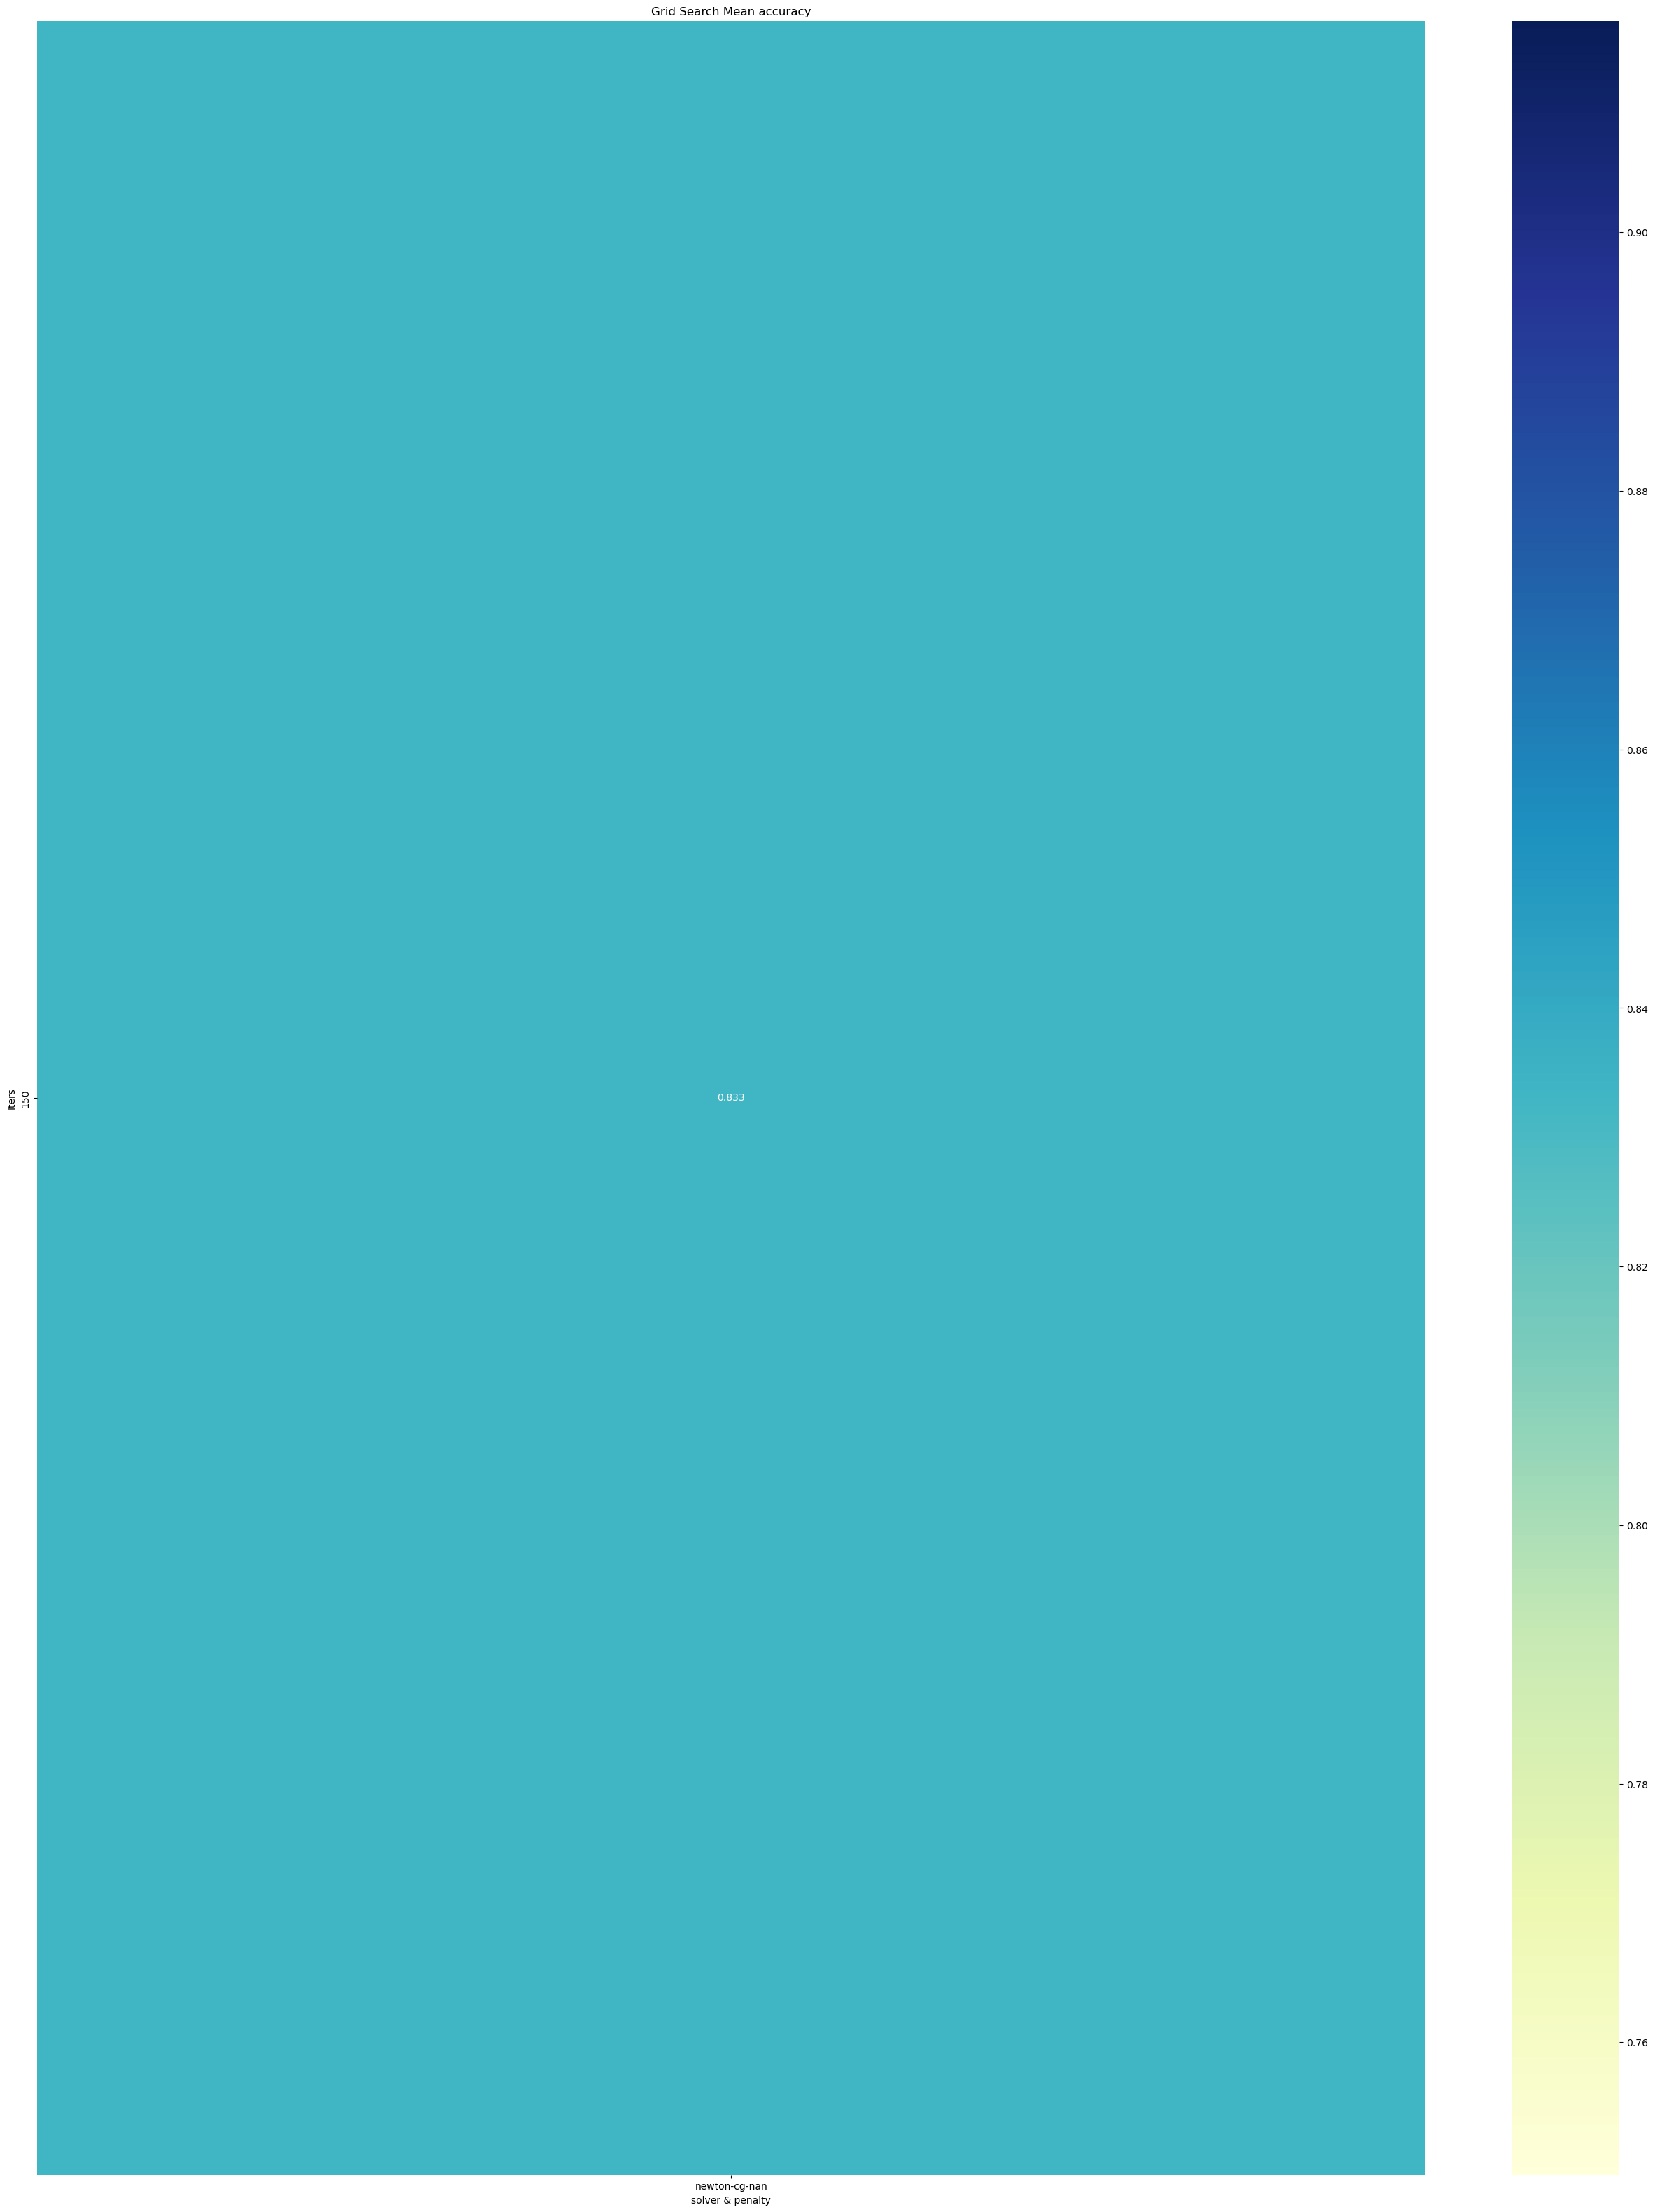

'Best Parameters:'

{'max_iter': 150, 'penalty': None, 'solver': 'newton-cg'}

In [27]:

colsToDrop=['Year','Pressure','Weather','Day','Hour','WindSpeed','Month']

# Create a Logistic Regression model
model = LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)  # You can specify the solver as needed

# Define the parameter grid for GridSearchCV
param_grid = {
    'penalty': [None],
    'solver': ['newton-cg'],
    'max_iter':[150],
} # Hyperparameter tunning

warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrainScaler(colsToDrop))

# Restore default warning settings 
warnings.simplefilter("default")
os.environ["PYTHONWARNINGS"] = "default"

# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(32, 40))
heatmap_data = results.pivot(index='param_max_iter', columns=['param_solver', 'param_penalty'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("solver & penalty")
plt.ylabel("Iters")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
display("Best Parameters:", best_params)

/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  

'Mean accuracy: 0.834331353611879'

'Mean f1: 0.8204859040513144'

'Mean precision: 0.8085964925537231'

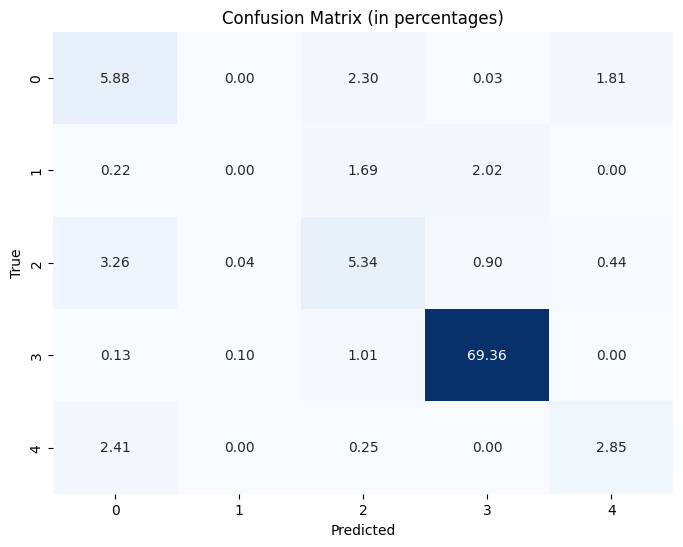

In [28]:
testAndSubmit(grid_search,'logistical.csv',scaler=True)

## Support Vector Machines

/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  

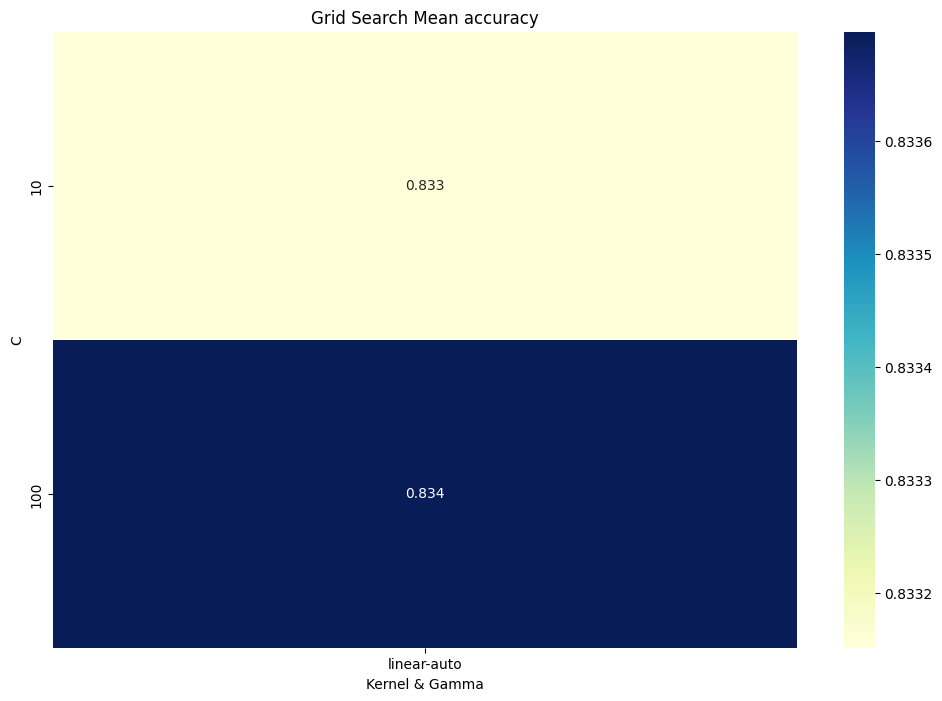

'Best Parameters:'

{'C': 100, 'gamma': 'auto', 'kernel': 'linear'}

In [31]:
# Create a Logistic Regression model
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day', 'Hour', 'WindSpeed', 'Month']


model = svm.SVC(random_state=25,cache_size=1000)  # You can specify the solver as needed

param_grid = {
    'C': [10],          # Regularization parameter
    'kernel': ['linear'], # Kernel type
    'gamma': [ 'auto'],  # Kernel coefficient
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrainScaler(colsToDrop))

results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_C', columns=['param_kernel', 'param_gamma'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("Kernel & Gamma")
plt.ylabel("C")
plt.show()

best_params = grid_search.best_params_

# Display the best parameters
display("Best Parameters:", best_params)

/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  

'Mean accuracy: 0.8341501950874555'

'Mean f1: 0.8197483151452909'

'Mean precision: 0.8178319254803863'

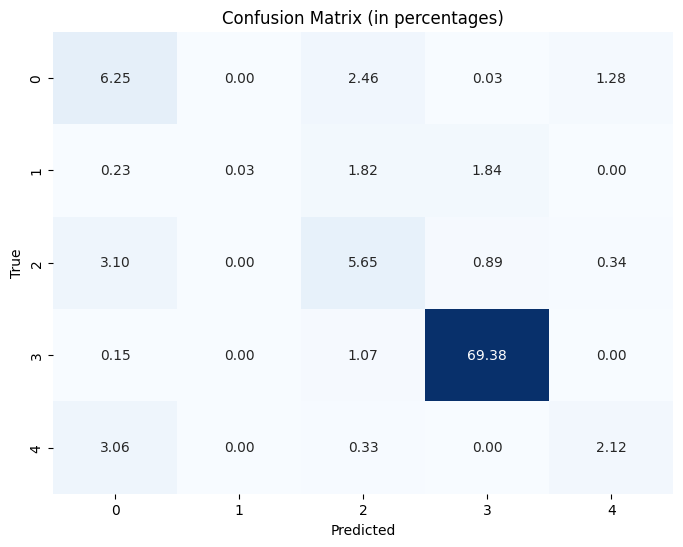

In [32]:
testAndSubmit(grid_search,'SVM.csv',scaler=True)

## Stochastic Gradient Descent

/tmp/ipykernel_3966992/2775722556.py:20: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_loss', columns=['param_penalty', 'param_alpha'], values='mean_test_score')


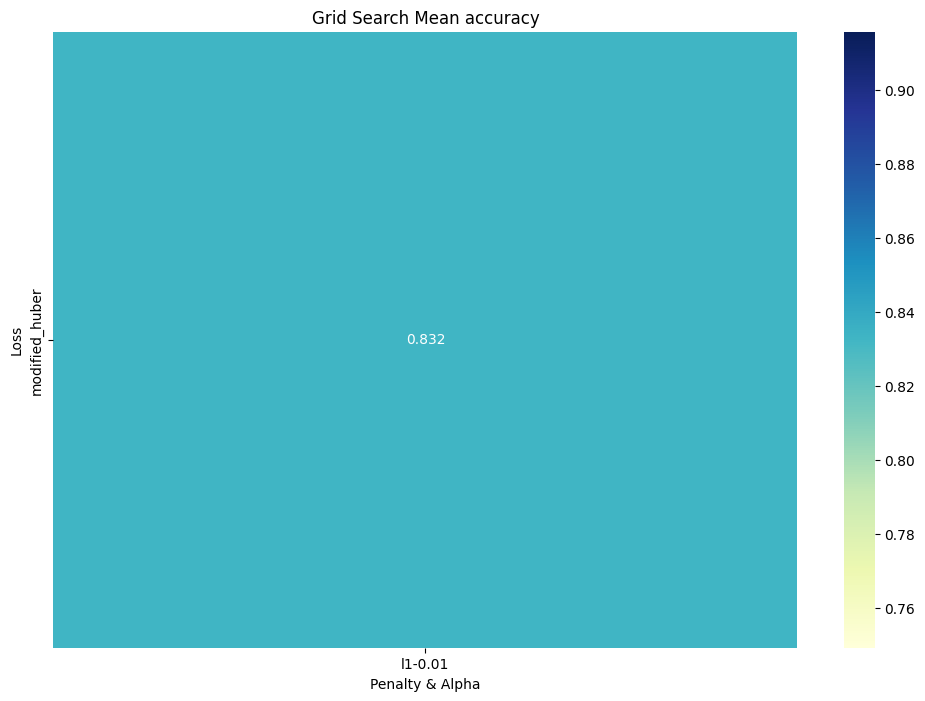

'Best Parameters:'

{'alpha': 0.01, 'loss': 'modified_huber', 'penalty': 'l1'}

In [32]:
# Create a Logistic Regression model
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day', 'Hour', 'WindSpeed', 'Month']


model = SGDClassifier(random_state=RANDOM_SEED)

param_grid = {
    'loss': ['modified_huber'],  # Loss function
    'penalty': ['l1'],        # Regularization type
    'alpha': [0.01],               # Regularization strength
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrainScaler(colsToDrop))

results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_loss', columns=['param_penalty', 'param_alpha'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("Penalty & Alpha")
plt.ylabel("Loss")
plt.show()

best_params = grid_search.best_params_

# Display the best parameters
display("Best Parameters:", best_params)

'Mean accuracy: 0.8317001043433541'

'Mean f1: 0.811698354145874'

'Mean precision: 0.7980886639455174'

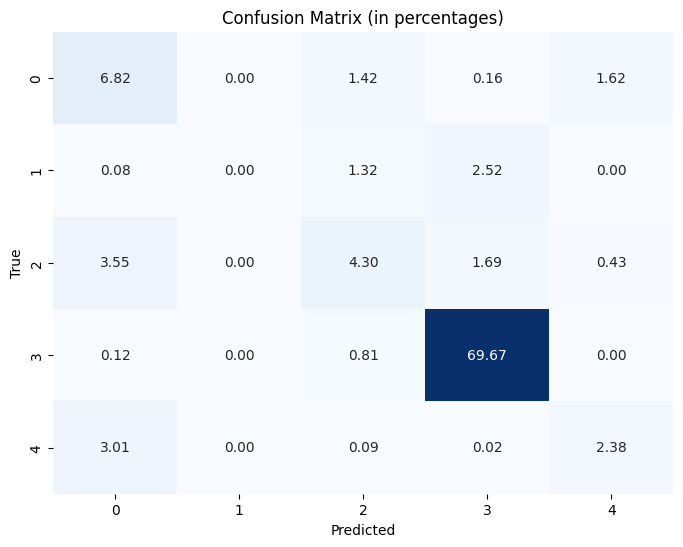

In [33]:
testAndSubmit(grid_search,'SGD.csv',scaler=True)

## NearestNeighbors

/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  

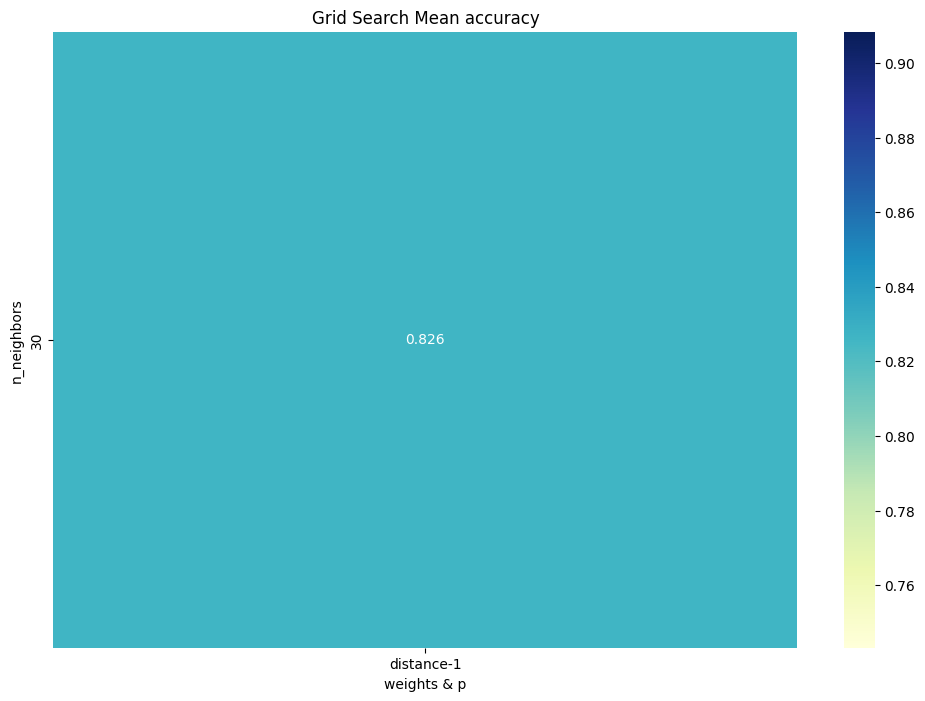

Best Parameters: {'n_neighbors': 30, 'p': 1, 'weights': 'distance'}


In [39]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day', 'Hour', 'WindSpeed', 'Month']

# Create a KNeighborsClassifier model
model = KNeighborsClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [30],             # Number of neighbors to consider
    'weights': ['distance'],   # Weight function used in prediction
    'p': [1],                          # Power parameter for the Minkowski metric
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrainScaler(colsToDrop))

results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_n_neighbors', columns=['param_weights', 'param_p'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("weights & p")
plt.ylabel("n_neighbors")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)

/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  

'Mean accuracy: 0.8264335672404727'

'Mean f1: 0.817573338319613'

'Mean precision: 0.8289295077050056'

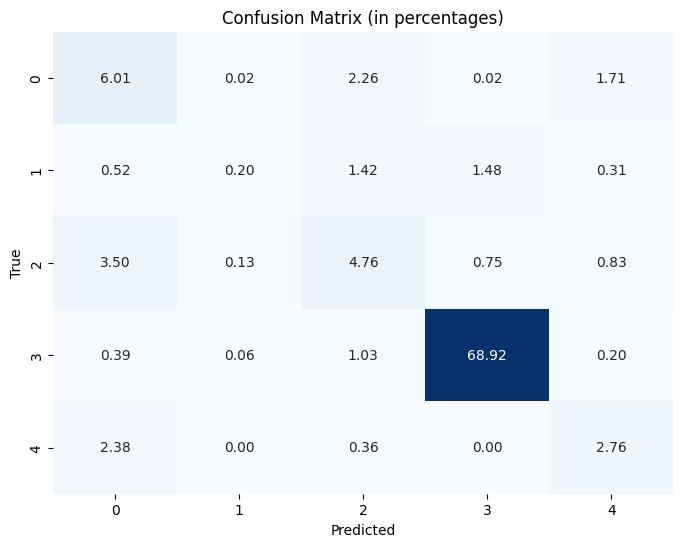

In [41]:
testAndSubmit(grid_search,'NearestNeighboar.csv',scaler=True)

## Decision tree classifier

/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/tmp/ipykernel_3966992/4115830244.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_criterion', columns=['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf'], values='mean_test_score')


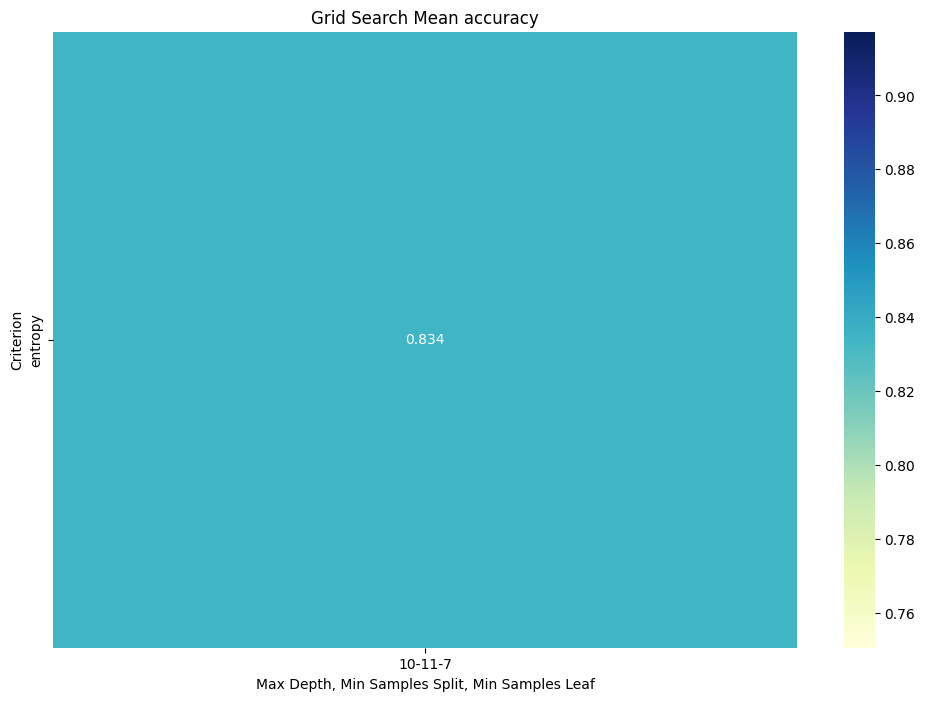

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 11}


In [46]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day', 'Hour', 'WindSpeed', 'Month']

# Create a Decision Tree Classifier model
model = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['entropy'],  # Split criterion
    'max_depth': [10],   # Maximum depth of the tree
    'min_samples_split': [11],   # Minimum samples required to split an internal node
    'min_samples_leaf': [7]      # Minimum samples required to be at a leaf node
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrain(colsToDrop))

# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_criterion', columns=['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("Max Depth, Min Samples Split, Min Samples Leaf")
plt.ylabel("Criterion")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)

/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


'Mean accuracy: 0.8330607713495898'

'Mean f1: 0.832205660574384'

'Mean precision: 0.8335477193956022'

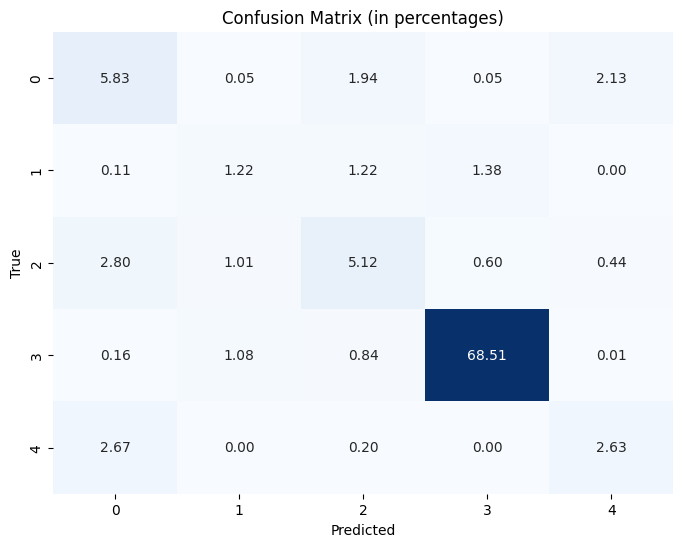

In [47]:
testAndSubmit(grid_search,'DecisionTree.csv')

## Random Forest

/tmp/ipykernel_1289494/3155957084.py:24: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_criterion', columns=['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf'], values='mean_test_score')


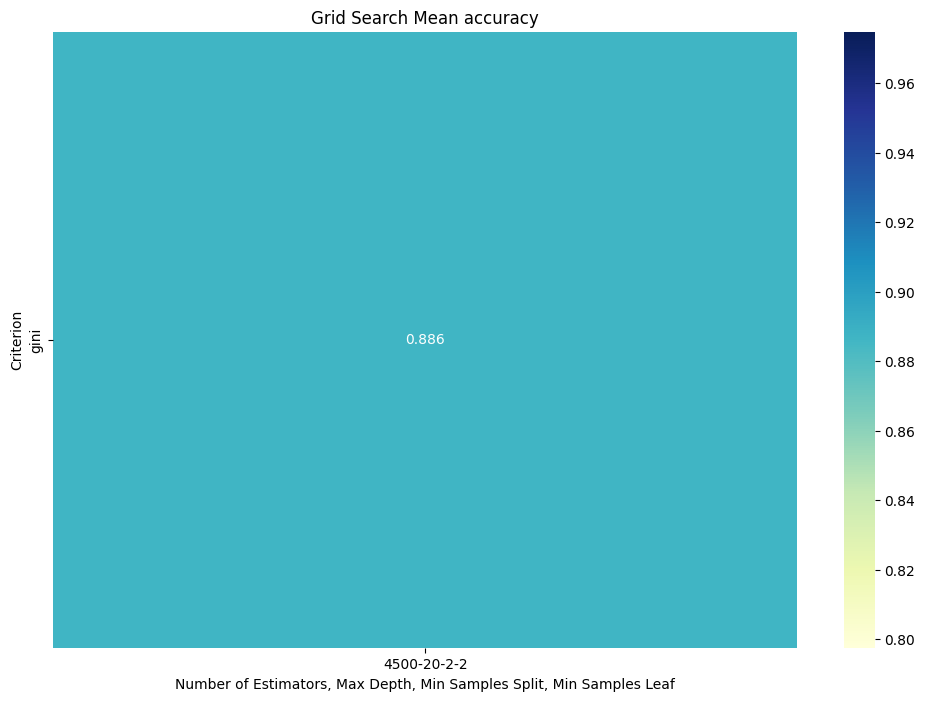

Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4500}


In [28]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day','ThermalSensation','MinTemperature','MaxTemperature',]

# Create a Random Forest Classifier model
model = RandomForestClassifier(random_state=RANDOM_SEED)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [4500],       # Number of trees in the forest
    'criterion': ['gini'],    # Split criterion
    'max_depth': [20],      # Maximum depth of the trees
    'min_samples_split': [2],      # Minimum samples required to split an internal node
    'min_samples_leaf': [2]         # Minimum samples required to be at a leaf node
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrainScaler(colsToDrop))

# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_criterion', columns=['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("Number of Estimators, Max Depth, Min Samples Split, Min Samples Leaf")
plt.ylabel("Criterion")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)


'Mean accuracy: 0.8861646976597747'

'Mean f1: 0.8809840669265829'

'Mean precision: 0.881374075717925'

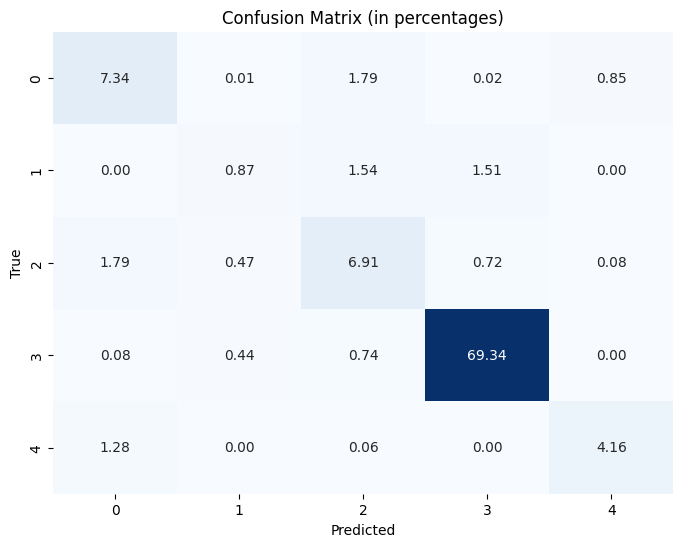

In [29]:
testAndSubmit(grid_search,'RandomForest.csv',scaler=True)

## Extra trees

/tmp/ipykernel_1796120/2755956882.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_n_estimators', columns=['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf'], values='mean_test_score')


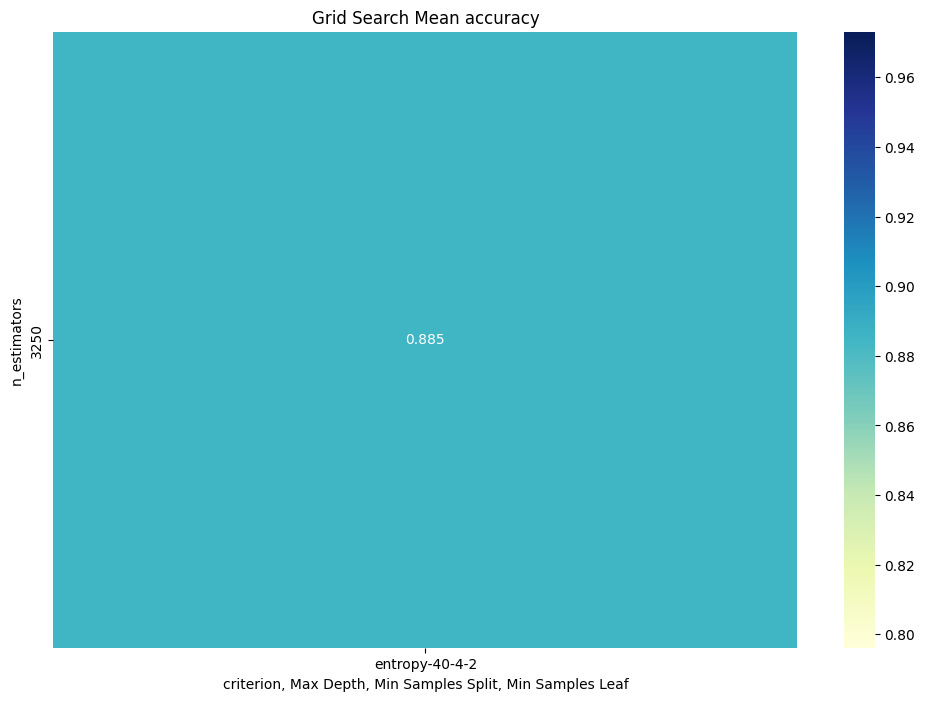

Best Parameters: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 3250}


In [32]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day','ThermalSensation','MinTemperature','MaxTemperature',]

# Create an ExtraTreesClassifier model
model = ExtraTreesClassifier(random_state=RANDOM_SEED)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [3250],         # Number of trees in the forest
    'criterion': ['entropy'],     # Split criterion
    'max_depth': [40],      # Maximum depth of the trees
    'min_samples_split': [4],          # Minimum samples required to split an internal node
    'min_samples_leaf': [2]            # Minimum samples required to be at a leaf node
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrain(colsToDrop))
# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_n_estimators', columns=['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("criterion, Max Depth, Min Samples Split, Min Samples Leaf")
plt.ylabel("n_estimators")
plt.show()
# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)

/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/luismfp/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


'Mean accuracy: 0.8858029575489036'

'Mean f1: 0.8780220559313104'

'Mean precision: 0.8804593396676553'

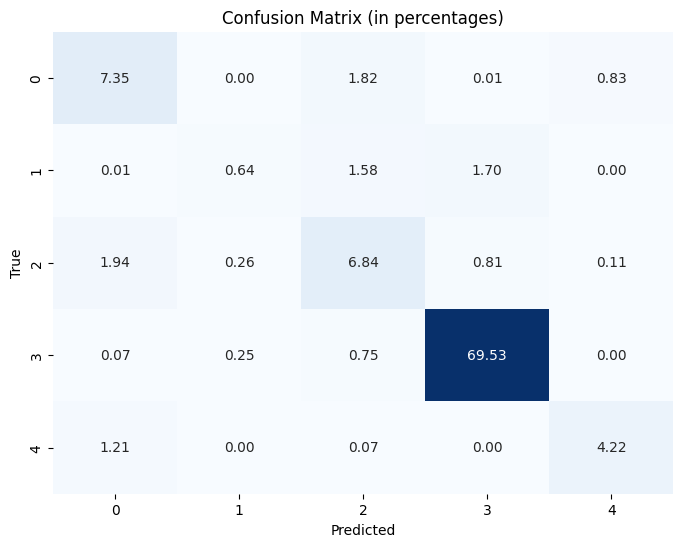

In [34]:
testAndSubmit(grid_search,'ExtraTrees.csv')

### Bagging with Random Forest:

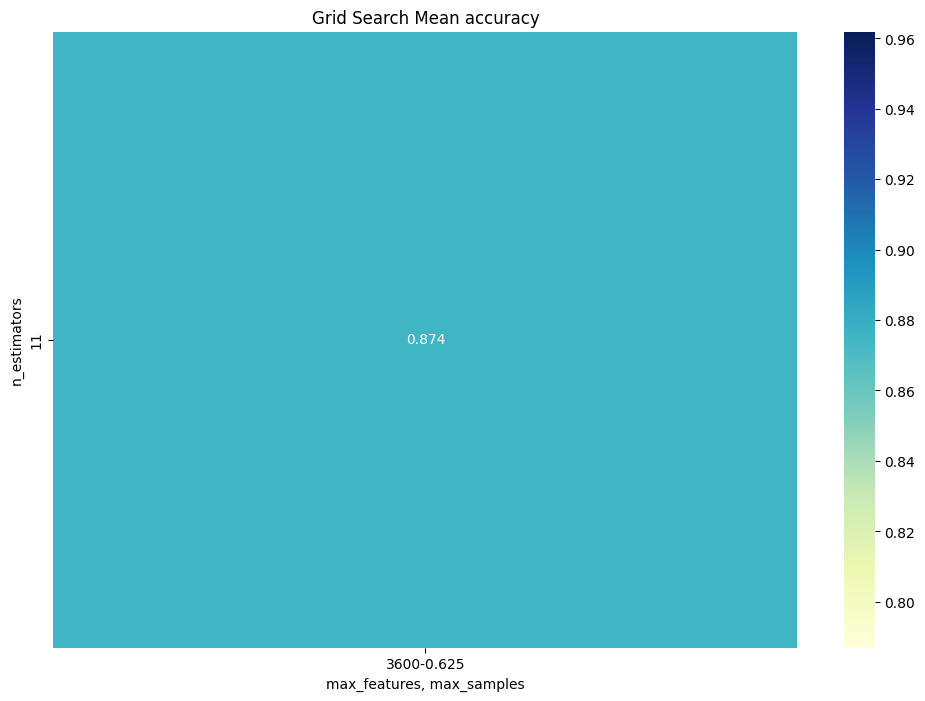

Best Parameters: {'max_features': 0.625, 'max_samples': 3600, 'n_estimators': 11}


In [34]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day','ThermalSensation','MinTemperature','MaxTemperature',]

# Create a base Random Fore  33t Classifier model
base_model = RandomForestClassifier(random_state=RANDOM_SEED,n_estimators=3000,max_depth=20,min_samples_split=2,min_samples_leaf=2)

# Create a Bagging Classifier with Random Forest as the base model
bagging_model = BaggingClassifier(base_model, random_state=RANDOM_SEED,n_jobs=-1)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [11],
    'max_features':[0.625],
    'max_samples':[3600]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrainScaler(colsToDrop))

# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_n_estimators', columns=['param_max_samples', 'param_max_features'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("max_features, max_samples")
plt.ylabel("n_estimators")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)


'Mean accuracy: 0.871277637389537'

'Mean f1: 0.8598162255377464'

'Mean precision: 0.8652723531882203'

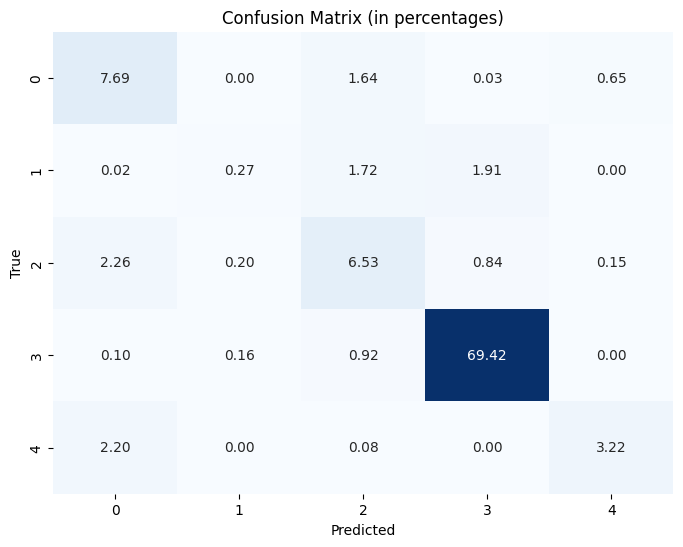

In [35]:
testAndSubmit(grid_search,'Bagging.csv',scaler=True)

### Boosting with AdaBoost:

In [ ]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day', 'Hour', 'WindSpeed', 'Month']

# Create a base Decision Tree Classifier model                             
base_model = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Create an AdaBoost Classifier with Decision Tree as t e base model
adaboost_model = AdaBoostClassifier(base_model, random_state=RANDOM_SEED)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of weak learners                   (base models)
    'learning_rate': [0.01, 0.1, 1.0]    # Weighting of weak learners
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=adaboost_model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrain(colsToDrop))

# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_n_estimators', columns=['param_learning_rate'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("learning_rate")
plt.ylabel("n_estimators")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)

In [ ]:
testAndSubmit(grid_search,'AdaBoost.csv')

### Extreme Gradient Boosting

/tmp/ipykernel_1398406/2670242545.py:29: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_learning_rate', columns=['param_n_estimators','param_max_depth','param_subsample','param_colsample_bytree','param_gamma','param_min_child_weight'], values='mean_test_score')


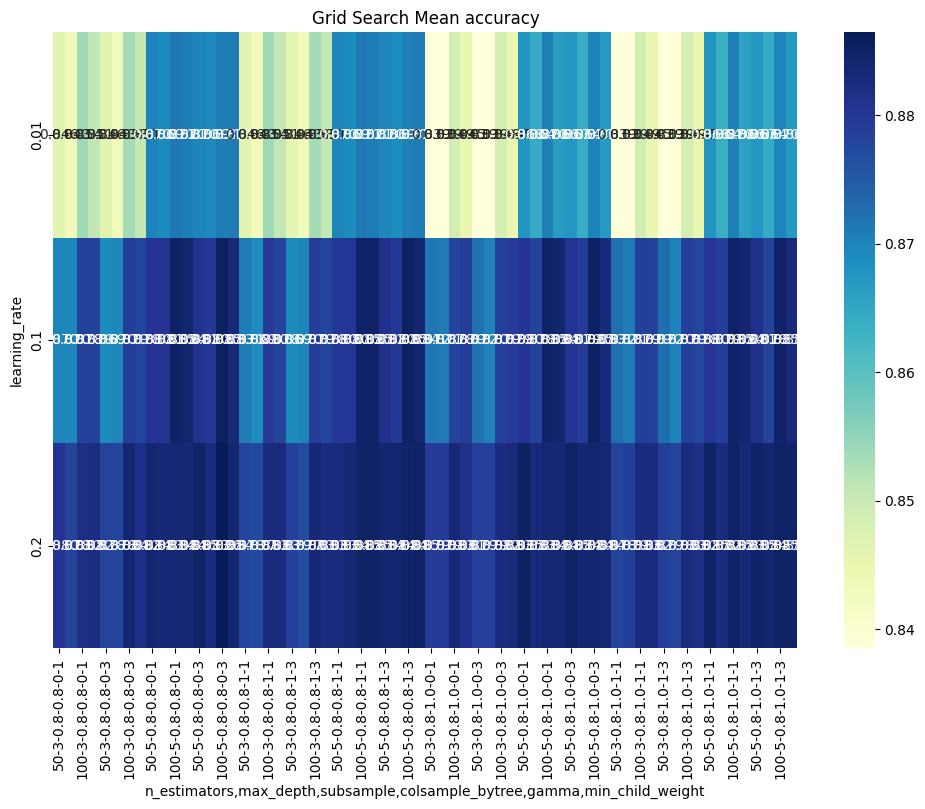

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


In [56]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day', 'Hour', 'WindSpeed', 'Month']

# Create an XGBClassifier model
model = XGBClassifier(random_state=RANDOM_SEED)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],   # Step size shrinkage
    'n_estimators': [50, 100, 200],       # Number of boosting rounds
    'max_depth': [3, 5, 7],               # Maximum depth of a tree
    'subsample': [0.8, 1.0],              # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0],       # Subsample ratio of columns when constructing each tree
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrain(colsToDrop))

# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_learning_rate', columns=['param_n_estimators','param_max_depth','param_colsample_bytree','param_subsample'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("n_estimators,max_depth,subsample,colsample_bytree")
plt.ylabel("learning_rate")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)

In [ ]:
testAndSubmit(grid_search,'EGB.csv')

### Stacking

In [ ]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day', 'Hour', 'WindSpeed', 'Month']

# Define base classifiers
base_classifiers = [
    ('random_forest', RandomForestClassifier(random_state=RANDOM_SEED)),
    ('svm', SVC(random_state=RANDOM_SEED)),
]

# Create a StackingClassifier with a meta-classifier (Logistic Regression)
model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(random_state=RANDOM_SEED),
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'final_estimator__C': [0.1, 1, 10],
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrain(colsToDrop))

# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_random_forest__n_estimators', columns=['param_random_forest__max_depth','param_svm__C','param_svm__kernel','param_final_estimator__C'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("random_forest__max_depth,svm__C,svm__kernel,final_estimator__C")
plt.ylabel("random_forest__n_estimators")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)

In [ ]:
testAndSubmit(grid_search,'Stacking.csv')

### Voting

In [ ]:
colsToDrop = ['Year', 'Pressure', 'Weather', 'Day', 'Hour', 'WindSpeed', 'Month']

# Define individual classifiers
classifier_rf = RandomForestClassifier(random_state=RANDOM_SEED)
classifier_svm = SVC(random_state=RANDOM_SEED)
classifier_lr = LogisticRegression(random_state=RANDOM_SEED)

# Create a VotingClassifier
model = VotingClassifier(
    estimators=[
        ('random_forest', classifier_rf),
        ('svm', classifier_svm),
        ('logistic_regression', classifier_lr),
    ],
    voting='hard',  # You can use 'soft' for weighted voting based on probabilities
)

# Define the parameter grid for GridSearchCV for each classifier
param_grid = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'logistic_regression__C': [0.1, 1, 10],
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kgs, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(*getXyTrain(colsToDrop))

# Store Grid Search results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot a heatmap for each combination of hyperparameters
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot(index='param_random_forest__n_estimators', columns=['param_random_forest__max_depth','param_svm__C','param_svm__kernel','param_logistic_regression__C'], values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Grid Search Mean accuracy")
plt.xlabel("random_forest__max_depth,svm__C,svm__kernel,logistic_regression__C")
plt.ylabel("random_forest__n_estimators")
plt.show()

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Display the best parameters
print("Best Parameters:", best_params)

In [ ]:
testAndSubmit(grid_search,'Voting.csv')